In [2]:
#Base libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from copy import deepcopy
import inspect
import fnmatch

from scipy.interpolate import NearestNDInterpolator
from scipy.interpolate import RegularGridInterpolator
from numpy.ma import masked_array
from scipy.interpolate import CubicSpline
from scipy import signal

from IPython.display import display, HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

from contourpy import contour_generator
from matplotlib.colors import BoundaryNorm

#Configuring relative file locations
homeDir = os.path.abspath("")
srcDir = os.path.join(homeDir,"src")
plotDir = os.path.join(homeDir,"plots")
dataDir = os.path.join(homeDir,"data")

In [3]:
#piv data structure definition

class planar_piv_data:
    """A class representing planar PIV data.
    Attributes:
    - deflt_grid_x: numpy.ndarray
        The default grid x-coordinates.
    - deflt_grid_z: numpy.ndarray
        The default grid z-coordinates.
    - grid_x: numpy.ndarray
        The grid x-coordinates.
    - grid_z: numpy.ndarray
        The grid z-coordinates.
    - deflt_grid_v_x: numpy.ndarray
        The default grid x-velocity.
    - grid_v_x: numpy.ndarray
        The grid x-velocity.
    - grid_v_z: numpy.ndarray
        The grid z-velocity.
    - grid_v_mag: numpy.ndarray
        The grid velocity magnitude.
    - grid_omega_y: numpy.ndarray
        The grid y-vorticity.
    - grid_omega_mag: numpy.ndarray
        The grid vorticity magnitude.
    - grid_r_xx: numpy.ndarray
        The grid xx Reynolds stress.
    - grid_r_xz: numpy.ndarray
        The grid xz Reynolds stress.
    - grid_r_zz: numpy.ndarray
        The grid zz Reynolds stress.
    - grid_std_v_x: numpy.ndarray
        The grid x-velocity standard deviation.
    - grid_std_v_z: numpy.ndarray
        The grid z-velocity standard deviation.
    - grid_valid_cell: numpy.ndarray
        The grid valid cell mask.
    Methods:
    - __init__(frame_i, frame_j, frame_data)
        Initializes the planar_piv_data object.
    - corr_frame(x_corr, z_corr, mode="absolute")
        Adjusts the grid_x and grid_z coordinates based on the given correction values.
    - reorient_frame(disc_xc, disc_zc)
        Reorients the frame of the grid by subtracting the given disc_xc and disc_zc values.
    - gen_data_intpr()
        Generates interpolated data for the object.
    """
      
    
    def __init__(self, frame_i, frame_j, frame_data):
        """
        Initializes the grid and velocity data for the given frames.
        Parameters:
        frame_i (int): Number of rows in the grid.
        frame_j (int): Number of columns in the grid.
        frame_data (numpy.ndarray): Array containing the grid and velocity data. 
            The array is expected to have the following columns:
            - Column 0: x-coordinates of the grid points.
            - Column 1: z-coordinates of the grid points.
            - Column 2: x-components of the velocity at the grid points.
            - Column 3: z-components of the velocity at the grid points.
            - Column 4: Magnitude of the velocity at the grid points.
            - Column 5: y-components of the vorticity at the grid points.
            - Column 6: Magnitude of the vorticity at the grid points.
            - Column 7: xx-components of the Reynolds stress at the grid points.
            - Column 8: xz-components of the Reynolds stress at the grid points.
            - Column 9: zz-components of the Reynolds stress at the grid points.
            - Column 10: Standard deviation of the x-components of the velocity.
            - Column 11: Standard deviation of the z-components of the velocity.
            - Column 12: Validity of the grid cells (boolean).
        """
        
        self.deflt_grid_x = frame_data[:,0].reshape(frame_i, frame_j, order='F')
        self.deflt_grid_z = frame_data[:,1].reshape(frame_i, frame_j, order='F')
        self.grid_x  = deepcopy(self.deflt_grid_x)
        self.grid_z = deepcopy(self.deflt_grid_z)
        self.deflt_grid_v_x = frame_data[:,2].reshape(frame_i, frame_j, order='F')
        self.grid_v_x = deepcopy(self.deflt_grid_v_x)
        self.grid_v_z = frame_data[:,3].reshape(frame_i, frame_j, order='F')
        self.grid_v_mag = frame_data[:,4].reshape(frame_i, frame_j, order='F')
        self.grid_omega_y = frame_data[:,5].reshape(frame_i, frame_j, order='F')
        self.grid_omega_mag = frame_data[:,6].reshape(frame_i, frame_j, order='F')
        self.grid_r_xx = frame_data[:,7].reshape(frame_i, frame_j, order='F')
        self.grid_r_xz = frame_data[:,8].reshape(frame_i, frame_j, order='F')
        self.grid_r_zz = frame_data[:,9].reshape(frame_i, frame_j, order='F')
        self.grid_std_v_x = frame_data[:,10].reshape(frame_i, frame_j, order='F')
        self.grid_std_v_z = frame_data[:,11].reshape(frame_i, frame_j, order='F')
        self.grid_valid_cell = frame_data[:,12].reshape(frame_i, frame_j, order='F').astype(bool)
        
    def corr_frame(self, x_corr, z_corr, mode = "absolute"):
        """
        Adjusts the grid_x and grid_z coordinates based on the given x_corr and z_corr values.
        Parameters:
        - x_corr: float or int
            The correction value to be added to the grid_x coordinates.
        - z_corr: float or int
            The correction value to be added to the grid_z coordinates.
        - mode: str, optional (default: "absolute")
            The mode of correction. It can be either "absolute" or "relative".
            - "absolute": Adds the correction values directly to the resetted grid_x and grid_z coordinates.
            - "relative": Adds the correction values to the existing grid_x and grid_z coordinates.
        Returns:
        None
        """
            
        if mode == "absolute":
            
            self.grid_x = deepcopy(self.deflt_grid_x)
            self.grid_z = deepcopy(self.deflt_grid_z)
            
            self.grid_x += x_corr
            self.grid_z += z_corr
            
        elif mode == "relative":
            
            self.grid_x += x_corr
            self.grid_z += z_corr
        
    def reorient_frame(self, disc_xc, disc_zc):
        """
        Reorients the frame of the grid by subtracting the given disc_xc and disc_zc values from the grid coordinates.
        Then, it multiplies the grid_x and grid_v_x values by -1, and divides the grid_x and grid_z values by 200.
        Parameters:
        - disc_xc: The x-coordinate of the disc
        - disc_zc: The z-coordinate of the disc
        """
        
        self.grid_x = deepcopy(self.deflt_grid_x)
        self.grid_z = deepcopy(self.deflt_grid_z)
        self.grid_v_x = deepcopy(self.deflt_grid_v_x)
               
        self.grid_x -= disc_xc
        self.grid_z -= disc_zc
        
        self.grid_x *= -1
        self.grid_v_x *= -1
        self.grid_x /= 200
        self.grid_z /= 200
        
    def set_disc_mask(self, x_min, x_max, z_min, z_max):
        
        self.disc_mask = np.logical_and(np.logical_and(self.grid_x >= x_min, self.grid_x <= x_max), np.logical_and(self.grid_z >= z_min, self.grid_z <= z_max))
        
    def gen_data_intpr(self):
        """
        Generate interpolated data for the given object.
        This method checks if the interpolated data already exists for the object. If it does, the interpolation is skipped.
        Otherwise, it interpolates the dependent data using the NearestNDInterpolator.
        Parameters:
        - self: The object instance.
        Returns:
        - None
        """
                
        for name, value in inspect.getmembers(self):
            
            if fnmatch.fnmatch(name, "grid*intpr"): 
                return
        
        for name, value in inspect.getmembers(self):
            
            if fnmatch.fnmatch(name, "grid*") and name != "grid_x" and name != "grid_z" and name != "grid_valid_cell":
            
                setattr(self, name + "_intpr", NearestNDInterpolator((self.grid_x.flatten(), self.grid_z.flatten()), getattr(self, name).flatten()))
                
def read_planar_piv_data(file_path):
    """
    Reads planar PIV data from a file and returns the data for two frames.
    Parameters:
    - file_path (str): The path to the file containing the PIV data.
    Returns:
    - tuple: A tuple containing two planar_piv_data objects, one for each frame.
    """
    
    frame0_grid_info = open(file_path).readlines()[2].split(",")
    
    frame0_plane_i = int(frame0_grid_info[1].split("=")[1])
    frame0_plane_j = int(frame0_grid_info[2].split("=")[1])
    
    frame0_data = np.loadtxt(file_path, skiprows=4, max_rows=frame0_plane_i * frame0_plane_j)
    
    frame1_grid_info = open(file_path).readlines()[(frame0_plane_i * frame0_plane_j) + 5].split(",")
    
    frame1_plane_i = int(frame1_grid_info[1].split("=")[1])
    frame1_plane_j = int(frame1_grid_info[2].split("=")[1])
    
    frame1_data = np.loadtxt(file_path, skiprows=(frame0_plane_i * frame0_plane_j) + 7, max_rows=frame1_plane_i * frame1_plane_j)
    
    return planar_piv_data(frame0_plane_i, frame0_plane_j, frame0_data), planar_piv_data(frame1_plane_i, frame1_plane_j, frame1_data)

In [4]:
# freestream velocity piv data

frame0_x_corr = -7.513
frame0_z_corr = 2.944

piv_pixel_pitch = 5.995
piv_window_size = 32
piv_overlap = 0.75
piv_frame_res = round((piv_window_size * (1 - piv_overlap) / piv_pixel_pitch),3)

piv_disc_xc = 35.878
piv_disc_zc = 1.601

piv_rho_inf = 1.195

piv_vinf_3_frame0, piv_vinf_3_frame1 = read_planar_piv_data(dataDir + "/surge_disc_2023_reprocess/freestream_vinf_3_0001.dat")
piv_vinf_2_frame0, piv_vinf_2_frame1 = read_planar_piv_data(dataDir + "/surge_disc_2023_reprocess/freestream_vinf_2_0001.dat")

piv_vinf_3 = 0.5 * (piv_vinf_3_frame0.grid_v_mag[80:160,90:180].mean() + piv_vinf_3_frame1.grid_v_mag[80:160,90:180].mean()).round(3)
piv_vinf_2 = 0.5 * (piv_vinf_2_frame0.grid_v_mag[80:160,90:180].mean() + piv_vinf_2_frame1.grid_v_mag[80:160,90:180].mean()).round(3)

In [5]:
#Disc p70 import and condition data

piv_p70_case_06_phase_00_frame0, piv_p70_case_06_phase_00_frame1 = read_planar_piv_data(dataDir + "/surge_disc_2023_reprocess/p70_case_06_phase_00_0001.dat")
piv_p70_case_06_phase_00_frame0.corr_frame(frame0_x_corr, frame0_z_corr)
piv_p70_case_06_phase_00_frame0.reorient_frame(piv_disc_xc, piv_disc_zc)
piv_p70_case_06_phase_00_frame0.gen_data_intpr()

piv_p70_case_06_phase_00_frame1.reorient_frame(piv_disc_xc, piv_disc_zc)
piv_p70_case_06_phase_00_frame1.set_disc_mask(-0.05,0.15,-0.55,0.55)

In [10]:
np.max(piv_p70_case_06_phase_00_frame0.grid_x)

2.1605

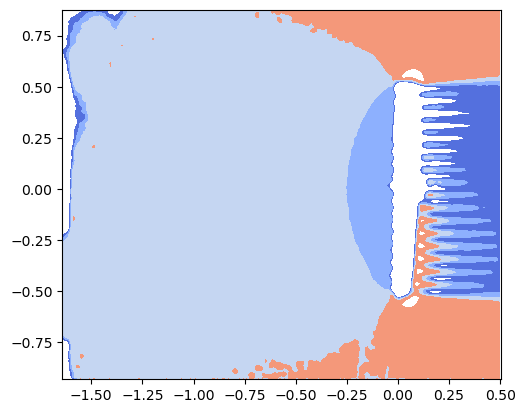

In [6]:
plt.contourf(piv_p70_case_06_phase_00_frame1.grid_x, piv_p70_case_06_phase_00_frame1.grid_z, piv_p70_case_06_phase_00_frame1.grid_v_x/piv_vinf_3, norm = mpl.colors.TwoSlopeNorm(vmin=0.7, vcenter=1.0, vmax=1.1), levels=np.linspace(0.7,1.1,5), cmap='coolwarm')
plt.gca().set_aspect('equal')

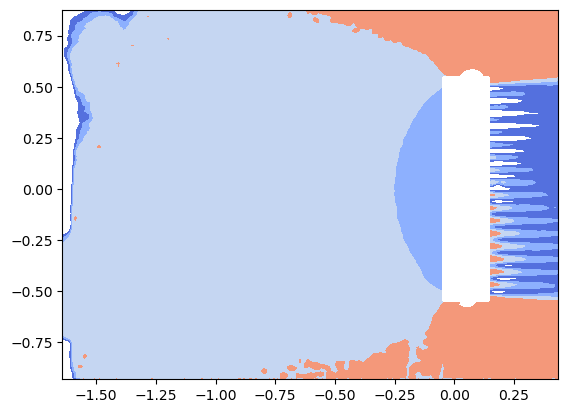

In [ ]:
grid_v_x_masked = masked_array(piv_p70_case_06_phase_00_frame1.grid_v_x, mask = piv_p70_case_06_phase_00_frame1.disc_mask)
plt.contourf(piv_p70_case_06_phase_00_frame1.grid_x[20:,:], piv_p70_case_06_phase_00_frame1.grid_z[10:,:], grid_v_x_masked[10:,:]/piv_vinf_3, norm = mpl.colors.TwoSlopeNorm(vmin=0.7, vcenter=1.0, vmax=1.1), levels=np.linspace(0.7,1.1,5), cmap='coolwarm')

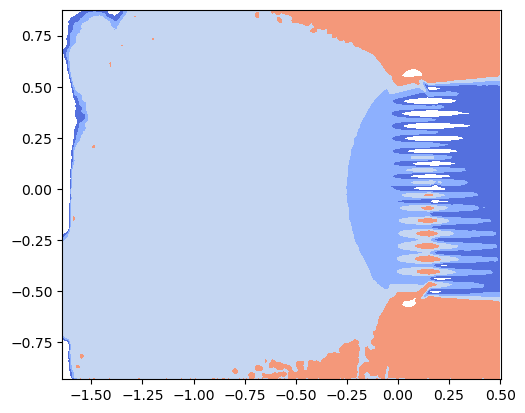

In [82]:
from scipy.interpolate import griddata

# Get the coordinates of the valid data points
valid_points = np.array((piv_p70_case_06_phase_00_frame1.grid_x[~piv_p70_case_06_phase_00_frame1.disc_mask],
                         piv_p70_case_06_phase_00_frame1.grid_z[~piv_p70_case_06_phase_00_frame1.disc_mask])).T

# Get the values of the valid data points
valid_values = piv_p70_case_06_phase_00_frame1.grid_v_x[~piv_p70_case_06_phase_00_frame1.disc_mask]

# Get the coordinates of the masked data points
masked_points = np.array((piv_p70_case_06_phase_00_frame1.grid_x[piv_p70_case_06_phase_00_frame1.disc_mask],
                          piv_p70_case_06_phase_00_frame1.grid_z[piv_p70_case_06_phase_00_frame1.disc_mask])).T

# Perform the interpolation
interpolated_values = griddata(valid_points, valid_values, masked_points, method='linear')

# Fill the masked values with the interpolated values
grid_v_x_filled = piv_p70_case_06_phase_00_frame1.grid_v_x.copy()
grid_v_x_filled[piv_p70_case_06_phase_00_frame1.disc_mask] = interpolated_values

# Plot the filled data
plt.contourf(piv_p70_case_06_phase_00_frame1.grid_x, piv_p70_case_06_phase_00_frame1.grid_z, grid_v_x_filled/piv_vinf_3, norm=mpl.colors.TwoSlopeNorm(vmin=0.7, vcenter=1.0, vmax=1.1), levels=np.linspace(0.7, 1.1, 5), cmap='coolwarm')
plt.gca().set_aspect('equal')
plt.show()